# Crime Rate Prediction Using Linear Regression
This dataset reflects arrest incidents in the City of Los Angeles dating back to 2010. This data is transcribed from original arrest reports that are typed on paper and therefore there may be some inaccuracies within the data. Some location fields with missing data are noted as (0.0000°, 0.0000°). Address fields are only provided to the nearest hundred block in order to maintain privacy. This data is as accurate as the data in the database. Please note questions or concerns in the comments. 
The dataset is available at [data.lacity.org](https://data.lacity.org/A-Safe-City/Arrest-Data-from-2010-to-Present/yru6-6re4). It contains about 1.31 million records.


In [1]:
import pandas as pd
import datetime as dt

data = pd.read_csv("Dataset/Arrest_Data_from_2010_to_Present.csv"); 
data['Arrest Date'] = data['Arrest Date'].astype('datetime64[ns]'); #Convert date to datetime object
pd.set_option('display.max_columns', None); #set pandas to print all columns as opposed to truncating
print(data.info()); 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310127 entries, 0 to 1310126
Data columns (total 17 columns):
Report ID                   1310127 non-null int64
Arrest Date                 1310127 non-null datetime64[ns]
Time                        1309932 non-null float64
Area ID                     1310127 non-null int64
Area Name                   1310127 non-null object
Reporting District          1310127 non-null int64
Age                         1310127 non-null int64
Sex Code                    1310127 non-null object
Descent Code                1310127 non-null object
Charge Group Code           1222098 non-null float64
Charge Group Description    1221577 non-null object
Arrest Type Code            1310127 non-null object
Charge                      1310127 non-null object
Charge Description          1222140 non-null object
Address                     1310127 non-null object
Cross Street                747661 non-null object
Location                    1310127 non-null objec

In [9]:
# Only use data from 2010 to 2018. Exclude data from Jan 1, 2019
dataset = data[data['Arrest Date'].dt.year != 2019]
# View all years in the filtered dataset
print(dataset.groupby(dataset['Arrest Date'].dt.year).count()['Report ID'], end='\n\n)

#Print the first few rows of the dataset
print(dataset.head(5))

Arrest Date
2010    162416
2011    157638
2012    163313
2013    152673
2014    139380
2015    126154
2016    118125
2017    107651
2018    104277
Name: Report ID, dtype: int64

    Report ID Arrest Date    Time  Area ID    Area Name  Reporting District  \
0     4248313  2015-02-24  1310.0       20      Olympic                2022   
2     4254777  2015-02-26  2010.0       19      Mission                1985   
6     4256466  2015-02-28  1430.0       18    Southeast                1824   
7     4256564  2015-02-28  1715.0       10  West Valley                1039   
10    4256815  2015-03-01   110.0       17   Devonshire                1794   

    Age Sex Code Descent Code  Charge Group Code Charge Group Description  \
0    37        M            H                5.0                 Burglary   
2    22        M            H                6.0                  Larceny   
6    22        M            B                5.0                 Burglary   
7    16        M            H          

In [13]:
print('The dataset remaining contains %d rows and %d columns.'% (dataset.shape[0], dataset.shape[1]))

The dataset remaining contains 1231627 rows and 17 columns.


### ANALYZE THE 2018 DATA  


In [15]:
# Find total number of Crimes recorded in 2018
B2018 = dataset[dataset['Arrest Date'].dt.year == 2018]
crimes2018 = B2018['Arrest Date'].count() 
print("In 2018, there were %d crimes recorded.\n" % crimes2018); 

# 2.0 Crime by areas
print("Show crime count by areas")
print("=========================")
print(B2018['Area Name'].groupby(B2018['Area Name']).count().reset_index(name='count').sort_values(['count'], ascending=False))


In 2018, there were 104277 crimes recorded.

Show crime count by areas
      Area Name  count
1       Central  10951
6     Hollywood   9715
13      Rampart   7345
12      Pacific   6778
0   77th Street   6259
17     Van Nuys   6193
15    Southwest   5927
9        Newton   5427
8   N Hollywood   4947
7       Mission   4357
11      Olympic   3898
4        Harbor   3875
14    Southeast   3601
5    Hollenbeck   3590
19  West Valley   3562
10    Northeast   3452
2    Devonshire   3146
16      Topanga   3094
3      Foothill   3006
18      West LA   2687
20     Wilshire   2467


### LINEAR LINE FITTING USING REGRESSION  
Linear fitting was done using Python Scikitlearn Library. First, get the count of crimes by year and plot against year to observe possible linear relationship. 

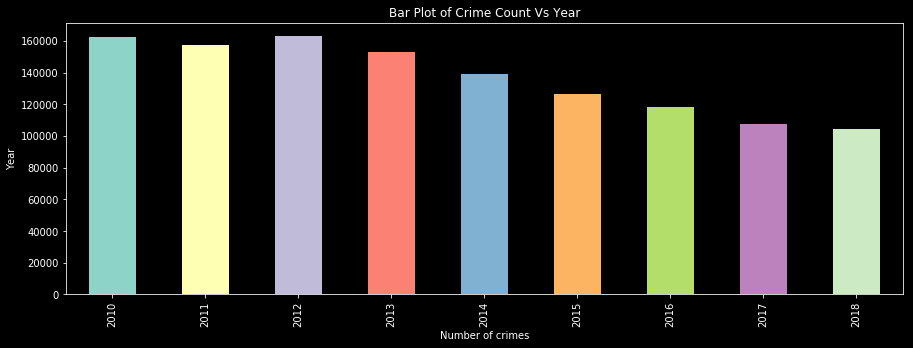

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Count the number of crimes by year
num_crimes = dataset['Arrest Date'].groupby(dataset['Arrest Date'].dt.year).count()
num_crimes.plot(kind='bar', title = 'Bar Plot of Crime Count Vs Year', figsize=(15, 5)); 
plt.xlabel('Number of crimes'); plt.ylabel('Year');

**Perform Linear fitting**  
1. Learn parameters of line of best fit by fitting the training data using scikitlearn's linear regression model.  
2. Measure how well the model performs on the training set by getting the R**2 score.  
3. Use the trained model to predict the crime count for 2018  


In [116]:
years = num_crimes.keys(); X = np.array(years).reshape(-1, 1)
Y = num_crimes.values
model = LinearRegression().fit(X.reshape(-1, 1), Y)
predicted_crimes = model.predict([[2019]])
print("The found model is: y = %.2fx + %.2f" % (model.coef_, model.intercept_))
print("The R-squared score of the model is: %.3f" % model.score(X.reshape(-1, 1), Y))
print("Number of crimes predicted for 2019 using Linear Estimation is %.0f" % predicted_crimes[0])

The found model is: y = -8323.53x + 16900443.58
The R-squared score of the model is: 0.940
Number of crimes predicted for 2019 using Linear Estimation is 95230


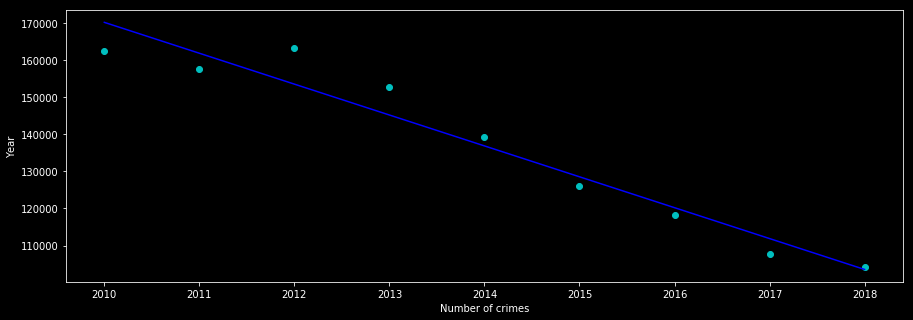

In [118]:
plt.figure(figsize=(15, 5))
plt.scatter(X.reshape(9), Y, color='c'); 
plt.plot(X.reshape(-1, 1), model.coef_*X + model.intercept_, color='b'); 
plt.xlabel('Number of crimes'); plt.ylabel('Year'); 

  

**Analyze Crimes by Area**  
Here, attempt to find the number of crimes within 2km from a specific location ***Bradbury Building (34.050536, -118.247861).*** In order to accomplish this, we use the spherical earth distance formula discussed [here](https://en.wikipedia.org/wiki/Geographical_distance#Spherical_Earth_projected_to_a_plane) with R = 6371km

In [120]:
# Location work - within 2km
import re
from math import sqrt, pi, cos
pd.set_option('mode.chained_assignment', None)

def get_dist_from_Building(x):
    R = 6371; c = (34.050536, -118.247861); #c is location of Bradbury Building 
    dphi = (c[0] - x[0])*pi/180.0;
    d_lamda = (c[1] - x[1])*pi/180.0;
    phi_m = (c[0] - x[0])*pi/(180.0* 2.0)
    return R * sqrt((dphi*dphi) + (cos(phi_m)*d_lamda)**2)

L = dataset[(dataset['Location'] != '(0.0, 0.0)') & (dataset['Arrest Date'].dt.year == 2018)]
lat_lon_re = re.compile(r'\((.*),\ (.*)\)')
L['Lat_Lng'] = [tuple(map(float,lat_lon_re.findall(p)[0])) for p in L['Location']]
L['dist'] = list(get_dist_from_Building(x) for x in L['Lat_Lng'])
count_crimes = L[(L['dist'] <= 2.0)].count()['Arrest Date'];
print("Number of arrest incidents within 2km from the Bradbury Building in 2018: %.0f" % count_crimes)


Number of arrest incidents within 2km from the Bradbury Building in 2018: 10883
